# 7. Custom Plugin

## Overview

Mitsuba is a plugin-oriented framework where custom code for BSDF, integrator, emitter, sensor, ... can easily be added to the system. In this tutorial we will see that custom plugins can also be implemented directly in Python and then registered into the system for futher use.

To illustrate this, we are going to implement a new *tinted dielectric* BSDF, that behaves much like a regular [dielectric](...) BSDF but adds a colorful tint to the reflections at grazing angle. We will then register this new BSDF and use it to render a simple scene.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Create a custom BSDF plugin in Python</li>
  <li>Register a custom plugin to the system</li>
  <li>Use a registered custom plugin</li>
</ul>
    
</div>


### Step 1 - setup

Custom Mitsuba plugins in Python work best with JIT variants as it would be pretty inefficient to execute Python BSDF code for millions of lights path. On the other hand, JIT variants perform only a few calls to those methods and it is the job of the JIT compiler to run those instructions on arrays containing millions of entries at once.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_ad_rgb')

### Step 2 - implement the custom plugin

As mentioned in the tutorial overview, we are going to implement a tinted dielectric BSDF in this tutorial. You will find that the code is very similar to the actual [C++ implementation](...) of the [dielectric](...) so we are not going to look at it much in details.

First, our BSDF Python class `MyBSDF` needs to inherit from `mitsuba.render.BSDF`. Then we can override both the constructor method as well as the `sample`, `eval` and `pdf` routines. 

The constructor method take a `mitsuba.core.Properties` object as argument, which can be used to read parameters defined in the XML scene description or passed in the `load_dict` dictionary. Here we read the index of refraction ratio `eta` as well as the tint color `tint` from `props`.

Similar to the regular dielectric BSDF, the `eval` and `pdf` method of our custom BSDF should always return `0.0` and never be called as it is a degenerate BSDF described by a Dirac delta distribution. 

Regarding the `sample` method, appart from the computation of the tinted reflection value `value_r`, the rest of code should be identical to the C++ implementation of [dielectric](...).

Note that it is also possible to override the `to_string` method which will be call in any printing/logging routine.

In [3]:
from mitsuba.core.xml import load_dict
from mitsuba.core import Float, UInt32, Frame3f, Color3f, ScalarColor3f
from mitsuba.render import BSDF, BSDFSample3f, BSDFFlags, fresnel, reflect, refract

class MyBSDF(BSDF):
    def __init__(self, props):
        BSDF.__init__(self, props)
        
        # Read 'eta' and 'tint' properties from `props`
        self.eta = 1.33
        if props.has_property('eta'):
            self.eta = props['eta']
            
        self.tint = props['tint']
        
        # Set the BSDF flags
        reflection_flags   = BSDFFlags.DeltaReflection   | BSDFFlags.FrontSide | BSDFFlags.BackSide
        transmission_flags = BSDFFlags.DeltaTransmission | BSDFFlags.FrontSide | BSDFFlags.BackSide        
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags
        
    def sample(self, ctx, si, sample1, sample2, active):
        # Compute Fresnel terms
        cos_theta_i = Frame3f.cos_theta(si.wi)        
        r_i, cos_theta_t, eta_it, eta_ti = fresnel(cos_theta_i, self.eta)
        t_i = 1.0 - r_i
         
        # Pick between reflection and transmission
        selected_r = (sample1 <= r_i) & active
        
        # Fill up the BSDFSample struct
        bs = BSDFSample3f()
        bs.pdf = ek.select(selected_r, r_i, t_i)
        bs.sampled_component = ek.select(selected_r, UInt32(0), UInt32(1))
        bs.sampled_type      = ek.select(selected_r, UInt32(+BSDFFlags.DeltaReflection),
                                                     UInt32(+BSDFFlags.DeltaTransmission))
        bs.wo = ek.select(selected_r,
                          reflect(si.wi),
                          refract(si.wi, cos_theta_t, eta_ti))
        bs.eta = ek.select(selected_r, 1.0, eta_it)
                
        # For reflection, tint based on the incident angle (more tint at grazing angle)
        value_r = ek.lerp(Color3f(self.tint), Color3f(1.0), cos_theta_i)    
        
        # For transmission, radiance must be scaled to account for the solid angle compression
        value_t = Color3f(1.0) * ek.sqr(eta_ti)
        
        value = ek.select(selected_r, value_r, value_t)

        return (bs, value)
        
    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0
    
    def eval_pdf(self, ctx, si, wo, active):
            return 0.0, 0.0
    
    def traverse(self, callback):
        callback.put_parameter('tint', self.tint)
    
    def parameters_changed(self, keys):
        print("🏝️ there is nothing else to do 🏝️")
    
    def to_string(self):
        return ('MyBSDF[\n'
                '    eta=%s,\n'
                '    tint=%s,\n'
                ']' % (self.eta, self.tint))

### Step 3 - register and instanciate the BSDF

Now that our custom BSDF plugin is implemented, we need to register it into the system for futher use. This can be done by calling the `mitsuba.render.register_bsdf` function, specifying the name to be used to instanciated this plugin. This function take a *constructor lambda* function as second parameter.

Similar functions exist for other types of plugins, e.g. `register_integrator`, `register_sensor`, `register_medium`, `register_phasefunction`, `register_emitter`. 

In [4]:
from mitsuba.render import register_bsdf
register_bsdf("mybsdf", lambda props: MyBSDF(props))

It is possible now to use this plugin as you would do with any other BSDF plugin. We can also set the appropriate properties of the BSDF expected in `MyBSDF.__init__`.

For the sake of this tutorial, we also print the BSDF instance which will use the overriden `to_string` method to display the internal parameters.

In [5]:
from mitsuba.core.xml import load_dict
my_bsdf = load_dict({
    'type' : 'mybsdf',
    'tint' : [0.2, 0.9, 0.2],
    'eta' : 1.33
})

print(my_bsdf)

MyBSDF[
    eta=1.3300000429153442,
    tint=[0.20000000298023224, 0.8999999761581421, 0.20000000298023224],
]


### Step 4 - render

Finally, let's use our custom BSDF in an actual scene and render it to see how our tinted BSDF looks like.

2021-06-22 09:49:43 INFO main [Scene] Embree ready. (took 17ms)

2021-06-22 09:49:43 INFO main [SamplingIntegrator] Start rendering...

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Computation graph recorded. (took 10ms)

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Code generation finished. (took 2ms)

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Rendering finished. (took 105ms)

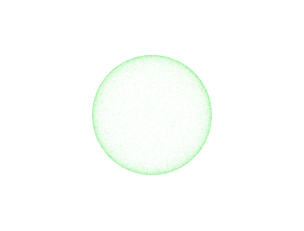

In [6]:
from matplotlib import pyplot as plt
from mitsuba.core import ScalarTransform4f
from mitsuba.python.util import render

scene = load_dict({
    'type' : 'scene',
    'integrator' : { 
        'type' : 'path' 
    },
    'light' : { 
        'type' : 'constant' 
    },
    'sphere' : {
        'type' : 'sphere',
        'bsdf' : my_bsdf
    },
    'sensor' : {
        'type' : 'perspective',
        'to_world' : ScalarTransform4f.look_at(origin=[0, -5, 5], 
                                               target=[0, 0, 0], 
                                               up=[0, 0, 1]),
    }
})

plt.imshow(render(scene)); plt.axis('off');

In [7]:
from mitsuba.python.util import traverse
params = traverse(scene)
print(params)

SceneParameters[
  * light.radiance.value,
    sensor.near_clip,
    sensor.far_clip,
    sensor.focus_distance,
    sensor.shutter_open,
    sensor.shutter_open_time,
    sensor.x_fov,
    sphere.to_world,
    sphere.bsdf.tint,
]


In [8]:
key = 'sphere.bsdf.tint'
params[key] = ScalarColor3f(0.9, 0.2, 0.2)
params.update()

🏝️ there is nothing else to do 🏝️


2021-06-22 09:49:44 INFO main [SamplingIntegrator] Start rendering...

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Computation graph recorded. (took 9ms)

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Code generation finished. (took 15ms)

2021-06-22 09:49:44 INFO main [SamplingIntegrator] Rendering finished. (took 102ms)

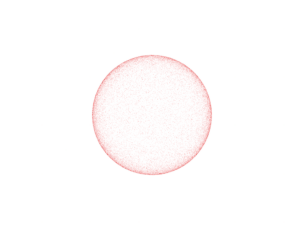

In [9]:
plt.imshow(render(scene)); plt.axis('off');

### *Reference API*

- [<code>mitsuba.render.register_bsdf</code>](...)